# Cifar10 Practice

## Set up the dataset

First download the dataset from https://www.cs.toronto.edu/~kriz/cifar.html and extact it.

In [6]:
dataset_dir = './'
batch_size = 50

In [7]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import pickle
import os

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

class cifar10Dataset(Dataset):
    '''
    The Cifar 10 dataset
    
    Args:
        root_dir:the root directory of the dataset
        type:'train' or 'test'
        transform
    '''
    def __init__(self, root_dir, type, transform = None):
        self.root_dir = root_dir
        self.transform = transform
        self.labels = []
        self.images = []

        self.loadData(type)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        label = self.labels[idx]
        image = Image.fromarray(self.images[idx])
        if self.transform:
            image = self.transform(image)

        return (image, label)



    def loadData(self, type):
        self.labels = []
        self.images = []
        if type == 'train':
            for i in range(1, 6):
                entry = unpickle(os.path.join(self.root_dir, 'cifar-10-batches-py', 'data_batch_'+str(i)))
                self.images.append(entry[b'data'])
                self.labels.append(entry[b'labels'])
            self.images = np.concatenate(self.images)
            self.labels = np.concatenate(self.labels)
            self.images = self.images.reshape(50000, 3, 32, 32)
            self.images = self.images.transpose((0, 2, 3, 1))
        elif type == 'test':
            entry = unpickle(os.path.join(self.root_dir, 'cifar-10-batches-py', 'test_batch'))
            self.images = (entry[b'data'])
            self.labels = (entry[b'labels'])
            self.images = self.images.reshape(10000, 3, 32, 32)
            self.images = self.images.transpose((0, 2, 3, 1))
        else: raise ValueError("no such type, must be 'train' or 'test'")

        return

We can get some information about the dataset.

Dataset sample


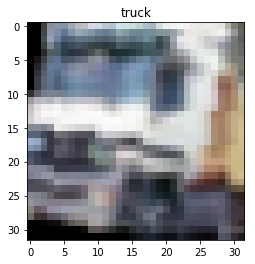

In [8]:
from torchvision import transforms
import matplotlib.pyplot as plt

label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

trans = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(32, scale=(0.7, 1.0))
])
dataset = cifar10Dataset(dataset_dir, 'train', trans)
image, label = dataset[1]
print('Dataset sample')
plt.figure()
plt.title(label_names[label])
plt.imshow(image)
plt.show()

Calculate the mean of the dataset to zero center the input data.

In [9]:
from PIL import ImageStat

mean = [0., 0., 0.]
for data in dataset:
    image = data[0]
    stat = ImageStat.Stat(image)
    for i in range(len(mean)):
        mean[i] += stat.mean[i]
for i in range(len(mean)):
    mean[i] /= len(dataset)*255

print(mean)

[0.4790731927083333, 0.46672274019607846, 0.43158152619485296]


Create the dataloaders for training

In [10]:
trans = {}
trans['train'] = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(32, scale=(0.7, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean, [1., 1., 1.])
])
trans['test'] = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, [1., 1., 1.])
])
datasets = {x: cifar10Dataset(dataset_dir, x, trans[x])for x in ['train', 'test']}
dataloaders = {x: DataLoader(datasets[x], batch_size=batch_size, shuffle=True, num_workers=4)
                for x in ['train', 'test']}
dataset_sizes = {x: len(datasets[x]) for x in ['train', 'test']}

In [11]:
dataset_sizes

{'test': 10000, 'train': 50000}

In [12]:
datasets['train'][0]

(tensor([[[-0.4791, -0.4791, -0.4791,  ..., -0.1810, -0.3340, -0.3497],
          [-0.4791, -0.4791, -0.4791,  ..., -0.1222, -0.2555, -0.2869],
          [-0.4791, -0.4791, -0.4791,  ..., -0.0752, -0.1653, -0.2085],
          ...,
          [-0.4791, -0.4791, -0.4791,  ...,  0.1523,  0.2190,  0.3092],
          [-0.4791, -0.4791, -0.4791,  ...,  0.1915,  0.1327, -0.4791],
          [-0.4791, -0.4791, -0.4791,  ..., -0.4791, -0.4791, -0.4791]],
 
         [[-0.4667, -0.4667, -0.4667,  ..., -0.2863, -0.3844, -0.3687],
          [-0.4667, -0.4667, -0.4667,  ..., -0.2471, -0.3452, -0.3412],
          [-0.4667, -0.4667, -0.4667,  ..., -0.2040, -0.2706, -0.2824],
          ...,
          [-0.4667, -0.4667, -0.4667,  ...,  0.0196,  0.1019,  0.2235],
          [-0.4667, -0.4667, -0.4667,  ...,  0.0862,  0.0548, -0.4667],
          [-0.4667, -0.4667, -0.4667,  ..., -0.4667, -0.4667, -0.4667]],
 
         [[-0.4316, -0.4316, -0.4316,  ..., -0.3532, -0.4081, -0.3649],
          [-0.4316, -0.4316,

## Model

In [13]:
import torch.nn as nn
import math

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.features = nn.Sequential(
            #32x32
            nn.Conv2d(3, 32, 3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            #16x16
            nn.Conv2d(64, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, 3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            #8x8
            nn.Conv2d(256, 512, 3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
            #4x4
        )

        self.classifier = nn.Sequential(
            nn.Linear(512 * 4 * 4, 2048),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(2048, 2048),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(2048, 10)
        )
        
        self._initialize_weights()
        

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()

## Training

Define the training parameters.

In [14]:
num_epochs = 40
learning_rate = 1e-4
regulization = 0
model_save_dir = './models'
model_name = 'net_v1_lr_1e-4_sgd_lr_sche_v2'
log_dir = './runs'

Initialization

In [15]:
import torch
import torch.optim as optim
from torch.autograd import Variable
from tensorboardX import SummaryWriter
from sklearn.metrics import accuracy_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
writer = {x: SummaryWriter(log_dir=os.path.join(log_dir, model_name, x),
                comment=model_name)
          for x in ['train', 'test']}

Define model, loss function, and optimizer

In [16]:
model = Model().to(device)
criterion = nn.CrossEntropyLoss(size_average=False)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=regulization)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20,30], gamma=0.1)

Start training

In [17]:
import time

def training():
    since = time.time()
    best_model_wts = model.state_dict()
    best_accuracy = 0.0
    iter_num = 0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        scheduler.step()
        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            # Iterate over data.
            for idx, data in enumerate(dataloaders[phase]):
                # get the inputs
                inputs, labels = data

                inputs = inputs.to(device)
                labels = labels.to(device)
                
                if phase == 'train':
                    torch.set_grad_enabled(True)
                else:
                    torch.set_grad_enabled(False)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                    iter_num += 1

                # statistics
                running_loss += loss.item()
                _, preds = torch.max(outputs.detach(), 1)
                running_corrects += torch.sum(preds == labels.detach()).item()

                if idx%10 == 0:
                    if phase == 'train':
                        preds = preds.to('cpu')
                        labels = labels.detach().to('cpu')
                        writer[phase].add_scalar('loss', loss.item()/len(preds), iter_num)
                        writer[phase].add_scalar('accuracy', accuracy_score(preds.numpy(), labels.numpy()), iter_num)
                    print('\r{} {:.2f}%'.format(phase, 100*idx/len(dataloaders[phase])), end='\r')
                if idx%500 == 499:
                    if phase == 'train':
                        for name, param in model.named_parameters():
                            writer[phase].add_histogram(name, param.detach().to('cpu').numpy(), iter_num)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_accuracy = running_corrects / dataset_sizes[phase]

            if phase == 'test':
                writer[phase].add_scalar('loss', epoch_loss, iter_num)
                writer[phase].add_scalar('accuracy', epoch_accuracy, iter_num)
            print('{} Loss: {:.4f} Accuracy: {:.4f}'.format(
                phase, epoch_loss, epoch_accuracy))

            # save model
            if phase == 'test' and epoch_accuracy > best_accuracy:
                best_accuracy = epoch_accuracy
                best_model_wts = model.state_dict()
                model_dir = os.path.join(model_save_dir, model_name+'.pth')
                if not os.path.exists(model_save_dir):
                    os.makedirs(model_dir)
                torch.save(model.state_dict(), model_dir)
                print('Model saved to %s'%(model_dir))

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best Test Accuracy: {:4f}'.format(best_accuracy))

    # load best model weights
    model.load_state_dict(best_model_wts)


In [13]:
training()

Epoch 0/39
----------
train Loss: 1.5978 Accuracy: 0.4103
test Loss: 1.3694 Accuracy: 0.5167
Model saved to ./models/net_v1_lr_1e-4_sgd_lr_sche_v2.pth

Epoch 1/39
----------
train Loss: 1.2755 Accuracy: 0.5444
test Loss: 1.1050 Accuracy: 0.5982
Model saved to ./models/net_v1_lr_1e-4_sgd_lr_sche_v2.pth

Epoch 2/39
----------
train Loss: 1.0986 Accuracy: 0.6116
test Loss: 0.9734 Accuracy: 0.6608
Model saved to ./models/net_v1_lr_1e-4_sgd_lr_sche_v2.pth

Epoch 3/39
----------
train Loss: 0.9893 Accuracy: 0.6538
test Loss: 0.8306 Accuracy: 0.7051
Model saved to ./models/net_v1_lr_1e-4_sgd_lr_sche_v2.pth

Epoch 4/39
----------
train Loss: 0.9040 Accuracy: 0.6848
test Loss: 0.8047 Accuracy: 0.7258
Model saved to ./models/net_v1_lr_1e-4_sgd_lr_sche_v2.pth

Epoch 5/39
----------
train Loss: 0.8439 Accuracy: 0.7081
test Loss: 0.7805 Accuracy: 0.7379
Model saved to ./models/net_v1_lr_1e-4_sgd_lr_sche_v2.pth

Epoch 6/39
----------
train Loss: 0.7849 Accuracy: 0.7275
test Loss: 0.6642 Accuracy: 0.

## Testing

In [40]:
model = Model()
model.load_state_dict(torch.load(os.path.join(model_save_dir, "net_v1_lr_1e-4_sgd_lr_sche_v2.pth"))) 
model.train(False)

trans = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, [1., 1., 1.])
])
dataset = cifar10Dataset(dataset_dir, 'test', trans)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=4)
dataiter = iter(dataloader)

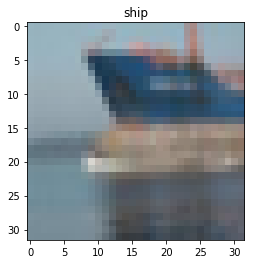

In [44]:
images, labels = dataiter.next()
plt.imshow(images[0].numpy().transpose((1, 2, 0))+mean)
plt.title(label_names[labels[0]])
plt.show()

In [47]:
import torch.nn.functional as F

out = F.softmax(model(images), dim=1)
print(label_names)
print(out[0])

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
tensor([ 0.1935,  0.0009,  0.0355,  0.0015,  0.0019,  0.0012,  0.0003,
         0.0005,  0.7596,  0.0052])
